## 线性模型的解释

导入依赖库：

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.linear_model import LinearRegression

import shap
shap.initjs()

导入数据集：

In [2]:
# a classic housing price dataset
X, y = shap.datasets.california(n_points=1000)

X100 = shap.utils.sample(X, 100) # 100 instances for use as the background distribution

模型训练：

In [3]:
# a simple linear model
model = LinearRegression()
model.fit(X, y)

LinearRegression()

获取模型参数：

In [4]:
print("Model coefficients:\n")
for i in range(X.shape[1]):
    print(X.columns[i], "=", model.coef_[i].round(5))

Model coefficients:

MedInc = 0.45769
HouseAge = 0.01153
AveRooms = -0.12529
AveBedrms = 1.04053
Population = 5e-05
AveOccup = -0.29795
Latitude = -0.41204
Longitude = -0.40125


PDP：

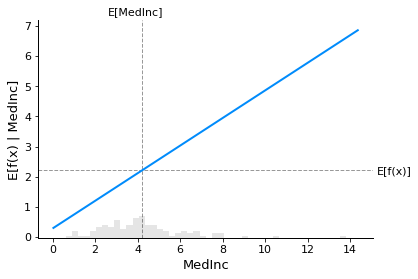

In [5]:
shap.partial_dependence_plot(
    "MedInc", model.predict, X100, ice=False,
    model_expected_value=True, feature_expected_value=True
)

## XGBoost模型解释

模型训练：

In [6]:
import xgboost
import shap

# train an XGBoost model
X, y = shap.datasets.boston()
model = xgboost.XGBRegressor().fit(X, y)


Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np

        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.
    :func:`~sklearn.datasets.fetch_california_housing`) and the Ames housing
    datase

模型解释：

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


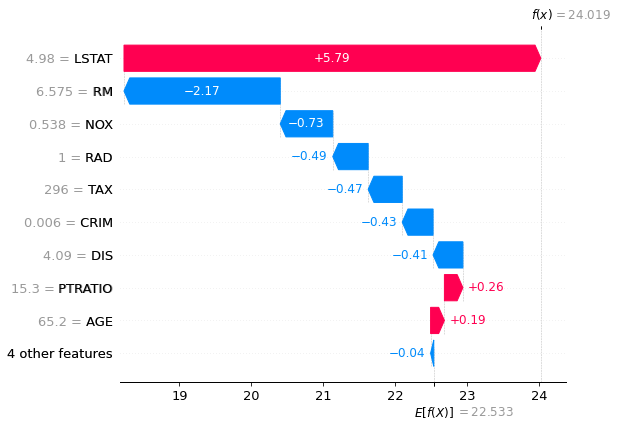

In [7]:
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(model)
shap_values = explainer(X)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

In [8]:
XX = shap_values[0]
XX

.values =
array([-4.2850167e-01, -6.6636719e-02,  7.7860229e-02, -1.5295845e-03,
       -7.2922713e-01, -2.1700280e+00,  1.9213372e-01, -4.1425934e-01,
       -4.9156108e-01, -4.7296646e-01,  2.5669456e-01, -5.3907130e-02,
        5.7883248e+00], dtype=float32)

.base_values =
22.532942

.data =
array([6.320e-03, 1.800e+01, 2.310e+00, 0.000e+00, 5.380e-01, 6.575e+00,
       6.520e+01, 4.090e+00, 1.000e+00, 2.960e+02, 1.530e+01, 3.969e+02,
       4.980e+00])

In [11]:
shap.plots.force(shap_values[0])

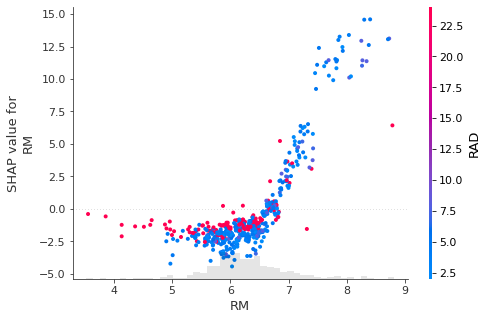

In [12]:
# create a dependence scatter plot to show the effect of a single feature across the whole dataset
shap.plots.scatter(shap_values[:,"RM"], color=shap_values)

In [15]:
yy = shap_values[:, 'RM']
yy

.values =
-2.170028

.base_values =
22.532942

.data =
6.575

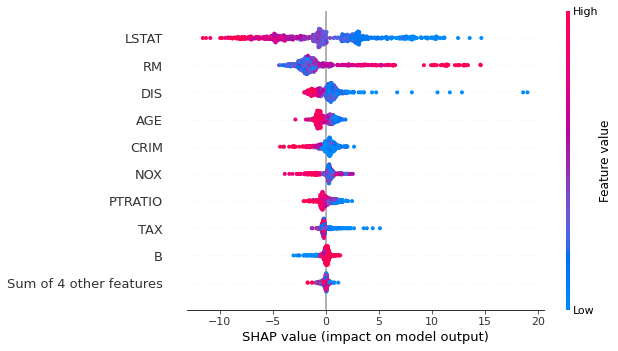

In [16]:
# summerize the effects of all the features
shap.plots.beeswarm(shap_values)

计算全局特征重要性：

In [1]:
shap.plots.bar(shap_values)

NameError: name 'shap' is not defined

dependence_plot与shap_interaction描述特征交互作用：

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


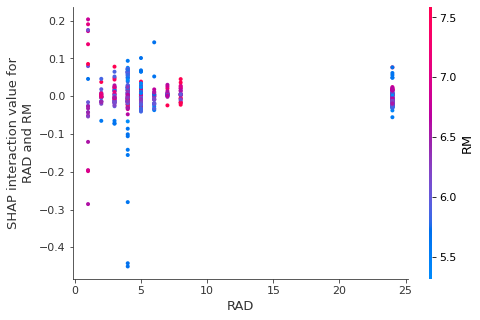

In [21]:
shap_interaction = explainer.shap_interaction_values(X)

# Experience-degree depenence plot
shap.dependence_plot(
    ("RAD", "RM"),
    shap_interaction, 
    X,
    display_features=X,
    show=False,
)

plt.savefig('./data/{}'.format('exp_degree_dependence.png'),dpi=200,bbox_inches='tight')

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5]),
 [Text(0, 0.5, 'CRIM'),
  Text(0, 1.5, 'ZN'),
  Text(0, 2.5, 'INDUS'),
  Text(0, 3.5, 'CHAS'),
  Text(0, 4.5, 'NOX'),
  Text(0, 5.5, 'RM'),
  Text(0, 6.5, 'AGE'),
  Text(0, 7.5, 'DIS'),
  Text(0, 8.5, 'RAD'),
  Text(0, 9.5, 'TAX'),
  Text(0, 10.5, 'PTRATIO'),
  Text(0, 11.5, 'B'),
  Text(0, 12.5, 'LSTAT')])

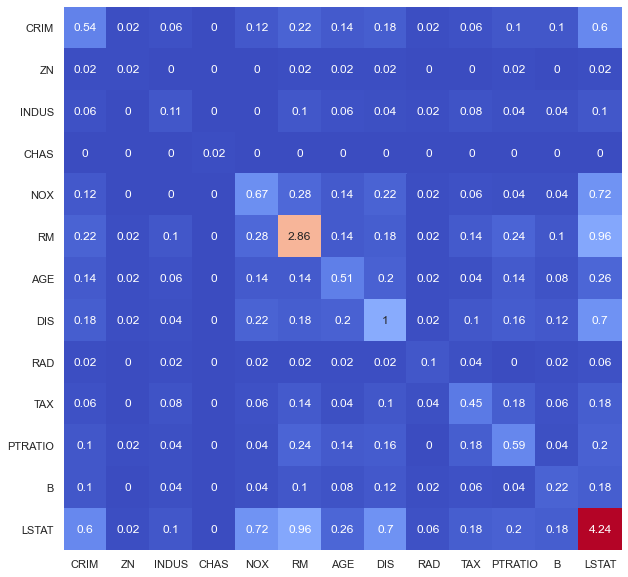

In [29]:
# Get absolute mean of matrices
mean_shap = np.around(np.abs(shap_interaction).mean(0),2)
df = pd.DataFrame(mean_shap,index=X.columns,columns=X.columns)

# times off diagonal by 2
df.where(df.values == np.diagonal(df),df.values*2,inplace=True)

# display 
plt.figure(figsize=(10, 10), facecolor='w', edgecolor='k')
sns.set(font_scale=1.0)
sns.heatmap(df,cmap='coolwarm',annot=True,fmt='.3g',cbar=False)
plt.yticks(rotation=0)

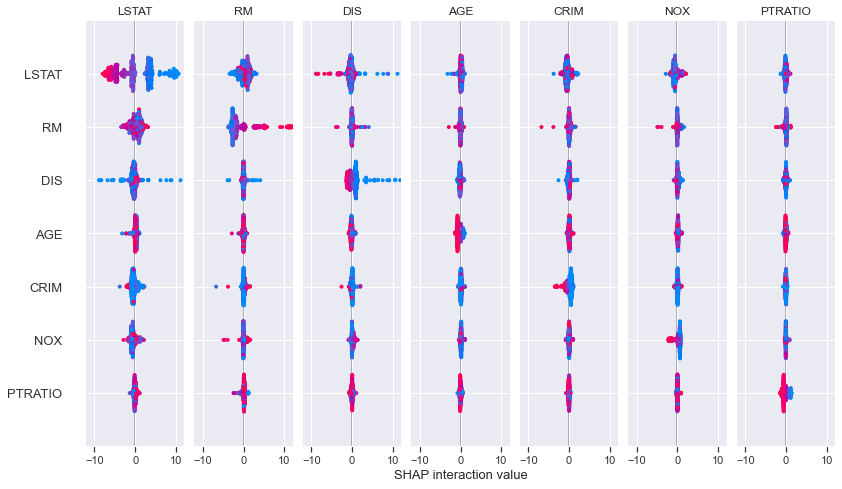

In [30]:
#Display summary plot
shap.summary_plot(shap_interaction, X)